(np.float64(-0.5), np.float64(9.5), np.float64(9.5), np.float64(-0.5))

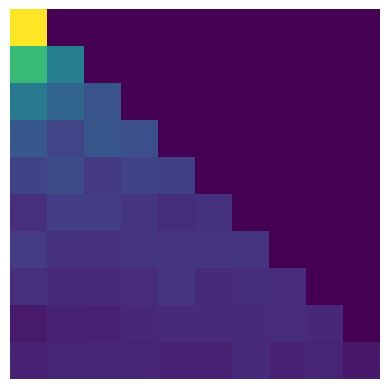

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F


class MultiHeadSelfAttention(nn.Module):
    """
    Multi-Head Self-Attention (batch_first).
    Input:  x  -> (B, T, D)
    Output: y  -> (B, T, D)
    Optional masks:
      - attn_mask: (T, T) or (B, T, T) where True means "mask out" (disallow).
      - key_padding_mask: (B, T) where True means "this token is padding" (disallow).
    """
    def __init__(self, embed_dim: int, num_heads: int, dropout: float = 0.0, bias: bool = True):
        super().__init__()
        if embed_dim % num_heads != 0:
            raise ValueError(f"embed_dim ({embed_dim}) must be divisible by num_heads ({num_heads}).")
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = 1.0 / math.sqrt(self.head_dim)

        # One big projection for Q, K, V (like PyTorch does)
        self.qkv = nn.Linear(embed_dim, 3 * embed_dim, bias=bias)
        self.out_proj = nn.Linear(embed_dim, embed_dim, bias=bias)
        self.dropout = nn.Dropout(dropout)

    def forward(
        self,
        x: torch.Tensor,
        attn_mask: torch.Tensor | None = None,
        need_weights: bool = False,
    ):
        """
        x: (B, T, D)
        attn_mask:
          - (T, T) or (B, T, T), dtype bool or float
            * bool: True = mask out
            * float: additive mask (e.g., -inf for masked positions)
        key_padding_mask:
          - (B, T), dtype bool, True = padding token (mask out)
        """
        B, T, D = x.shape
        if D != self.embed_dim:
            raise ValueError(f"Expected embed_dim={self.embed_dim}, got {D}.")

        # Project once, then split
        qkv = self.qkv(x)  # (B, T, 3D)
        q, k, v = qkv.chunk(3, dim=-1)  # each (B, T, D)

        # Reshape to heads: (B, H, T, d)
        q = q.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)

        # Scaled dot-product attention scores: (B, H, T, T)
        scores = (q @ k.transpose(-2, -1)) * self.scale

        # Apply attention mask (causal or custom)
        if attn_mask is not None:
            # Accept (T, T) or (B, T, T). We'll broadcast over heads.
            if attn_mask.dim() == 2:
                scores = scores.masked_fill(attn_mask[None, None, :, :], float("-inf"))
            elif attn_mask.dim() == 3:
                scores = scores.masked_fill(attn_mask[:, None, :, :], float("-inf"))
            else:
                raise ValueError("attn_mask must be (T,T) or (B,T,T) when bool.")


        # Softmax -> attention probs
        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)

        # Weighted sum: (B, H, T, d)
        y = attn @ v

        # Merge heads back: (B, T, D)
        y = y.transpose(1, 2).contiguous().view(B, T, D)
        y = self.out_proj(y)

        if need_weights:
            # Often people return average attention over heads: (B, T, T)
            return y, attn.mean(dim=1)
        return y


# ---- Example usage ----
B = 32
T = 10
D = 100
n = 10

from torchinfo import summary
attn = MultiHeadSelfAttention(embed_dim=D, num_heads=n, dropout=0.1)

# Causal mask: prevent attending to future tokens

causal = torch.triu(torch.ones(T, T, dtype=torch.bool), diagonal=1)

x = torch.randn(B,T,D)
y, weight = attn(x, need_weights=True, attn_mask=causal)


import matplotlib.pyplot as plt
plt.figure()
plt.imshow(weight[0,...].cpu().detach())
plt.axis('Off')

summary(attn, input_size=[B, T, D])